In [1]:
pip install haystack-ai

In [2]:
pip install chroma-haystack

In [3]:
%pip install "sentence-transformers>=2.2.0"

In [4]:
pip install pypdf

In [5]:
pip install google-ai-haystack

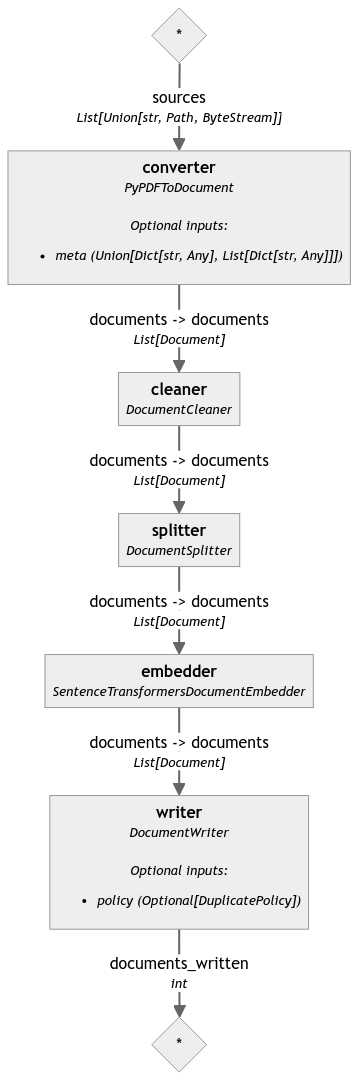

In [6]:
from haystack_integrations.document_stores.chroma import ChromaDocumentStore
from haystack import Pipeline
from haystack.components.converters import PyPDFToDocument
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

document_store = ChromaDocumentStore()

pipeline = Pipeline()

pipeline.add_component("converter", PyPDFToDocument())
pipeline.add_component("cleaner", DocumentCleaner())
pipeline.add_component("splitter", DocumentSplitter(split_by="sentence", split_length=5))
pipeline.add_component("embedder", SentenceTransformersDocumentEmbedder())
pipeline.add_component("writer", DocumentWriter(document_store=document_store))
pipeline.connect("converter", "cleaner")
pipeline.connect("cleaner", "splitter")
pipeline.connect("splitter", "embedder")
pipeline.connect("embedder", "writer")

In [7]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
os.environ["HF_API_TOKEN"] = userdata.get('hf')

In [8]:
book1 = "/content/book1.pdf"
book2 = "/content/book2.pdf"

pipeline.run({"converter": {"sources": [book1, book2]}})

/usr/local/lib/python3.10/dist-packages/sentence_transformers/SentenceTransformer.py:93: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v3 of SentenceTransformers.
  warnings.warn(


Batches:   0%|          | 0/82 [00:00<?, ?it/s]

{'writer': {'documents_written': 2595}}

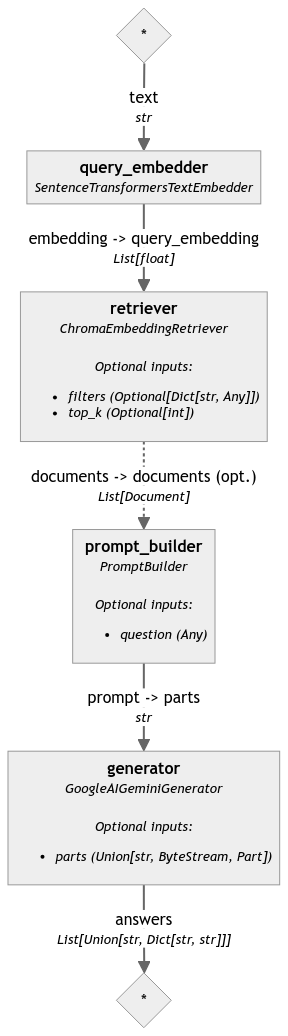

In [9]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack_integrations.components.retrievers.chroma import ChromaEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator


template = """
Given the following context, answer the question. If you are not sure about the answer, answer with "I don't know".

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

rag = Pipeline()

rag.add_component("query_embedder", SentenceTransformersTextEmbedder())
rag.add_component("retriever", ChromaEmbeddingRetriever(document_store))
rag.add_component("prompt_builder", PromptBuilder(template=template))
rag.add_component("generator", GoogleAIGeminiGenerator(model="gemini-pro"))

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever", "prompt_builder.documents")
rag.connect("prompt_builder", "generator")

In [12]:
questions = ["Which professor can transform herself into a cat?",
             "Who can transform into a cat?",
             "What is Ron's pet's name?",
             "Who is the headmaster of Hogwarts?",
             "Who's hand was bleeding?",
             "Who is Dobby?",
             "What is fatal to Basilisk?",
             "What did harry do to the diary?",
             "Who stopped Harry's letters?"]

for question in questions:
  results = rag.run({"query_embedder": {"text": question},
                    "prompt_builder": {"question": question}})
  print("Ques: ", question)
  print("Ans:  ", results["generator"]["answers"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ques:  Which professor can transform herself into a cat?
Ans:   Professor McGonagall


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ques:  Who can transform into a cat?
Ans:   I don't know.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ques:  What is Ron's pet's name?
Ans:   Scabbers


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ques:  Who is the headmaster of Hogwarts?
Ans:   Albus Dumbledore


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ques:  Who's hand was bleeding?
Ans:   Ron


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ques:  Who is Dobby?
Ans:   Dobby is a house-elf who is bound to serve one house and one family for ever.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ques:  What is fatal to Basilisk?
Ans:   The crowing of a rooster


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ques:  What did harry do to the diary?
Ans:   harry plunged the Basilisk fang into the heart of the diary


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Ques:  Who stopped Harry's letters?
Ans:   Uncle Vernon
